In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as BaseDataset
import os
import cv2
import numpy as np
from time import time


In [1]:
write_to_path = "/home/ufh6ft"
model_name = "trained_model_w_25"




In [2]:
NUM_EPOCHS = 100
wt_val = 25.0

In [3]:
def dice_score(target, pred):
    intersection = np.sum(  np.multiply(target, pred)  )
    cardinality = np.sum(target) + np.sum(pred)
    dice_score = 2. * intersection / (cardinality + 0.00001)
    return min(1, dice_score)

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
class SegNet(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(SegNet, self).__init__()
        self.encoder1 = Encorder2Convs(in_chan_num, 64)
        self.encoder2 = Encorder2Convs(64, 128)
        self.encoder3 = Encorder3Convs(128, 256)
        self.encoder4 = Encorder3Convs(256, 512)
        self.encoder5 = Encorder3Convs(512, 512)

        self.decoder1 = Decorder3Convs(512, 512)
        self.decoder2 = Decorder3Convs(512, 256)
        self.decoder3 = Decorder3Convs(256, 128)
        self.decoder4 = Decorder2Convs(128, 64)
        self.decoder5 = Decorder2Convs(64, out_chan_num)

        self.encoder_list = [self.encoder1, self.encoder2, self.encoder3, self.encoder4, self.encoder5]

        if in_chan_num == 3:
            self.set_weight()

    def forward(self, input):
        output, indices1, unpooled_shape1 = self.encoder1(input)
        output, indices2, unpooled_shape2 = self.encoder2(output)
        output, indices3, unpooled_shape3 = self.encoder3(output)
        output, indices4, unpooled_shape4 = self.encoder4(output)
        output, indices5, unpooled_shape5 = self.encoder5(output)

        output = self.decoder1(output, indices5, unpooled_shape5)
        output = self.decoder2(output, indices4, unpooled_shape4)
        output = self.decoder3(output, indices3, unpooled_shape3)
        output = self.decoder4(output, indices2, unpooled_shape2)
        output = self.decoder5(output, indices1, unpooled_shape1)

        return output

    def set_weight(self):
        vgg16 = models.vgg16(pretrained=True)
        self.vgg16_conv2d_layers = [layer for layer in vgg16.features if isinstance(layer, nn.Conv2d)]

        for encorder in self.encoder_list:
            if isinstance(encorder, Encorder2Convs):
                self._set_weight_encorder2convs(encorder)
            if isinstance(encorder, Encorder3Convs):
                self._set_weight_encorder3convs(encorder)

        assert (len(self.vgg16_conv2d_layers)) == 0

    def _set_weight_encorder2convs(self, encorder):
        self.__set_weight(encorder.conv_batch_relu1.conv)
        self.__set_weight(encorder.conv_batch_relu2.conv)

    def _set_weight_encorder3convs(self, encorder):
        self.__set_weight(encorder.conv_batch_relu1.conv)
        self.__set_weight(encorder.conv_batch_relu2.conv)
        self.__set_weight(encorder.conv_batch_relu3.conv)

    def __set_weight(self, conv_layer):
        conv_layer.weight.data = self.vgg16_conv2d_layers.pop(0).weight.data


class Encorder2Convs(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(Encorder2Convs, self).__init__()
        self.conv_batch_relu1 = ConvBatchReLU(in_chan_num, out_chan_num)
        self.conv_batch_relu2 = ConvBatchReLU(out_chan_num, out_chan_num)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, input):
        output = self.conv_batch_relu1(input)
        output = self.conv_batch_relu2(output)
        unpooled_shape = output.size()
        output, indices = self.pool(output)

        return output, indices, unpooled_shape


class Encorder3Convs(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(Encorder3Convs, self).__init__()
        self.conv_batch_relu1 = ConvBatchReLU(in_chan_num, out_chan_num)
        self.conv_batch_relu2 = ConvBatchReLU(out_chan_num, out_chan_num)
        self.conv_batch_relu3 = ConvBatchReLU(out_chan_num, out_chan_num)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, input):
        output = self.conv_batch_relu1(input)
        output = self.conv_batch_relu2(output)
        output = self.conv_batch_relu3(output)
        unpooled_shape = output.size()
        output, indices = self.pool(output)

        return output, indices, unpooled_shape


class Decorder2Convs(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(Decorder2Convs, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv_batch_relu1 = ConvBatchReLU(in_chan_num, out_chan_num)
        self.conv_batch_relu2 = ConvBatchReLU(out_chan_num, out_chan_num)

    def forward(self, input, indices, output_shape):
        output = self.unpool(input, indices, output_shape)
        output = self.conv_batch_relu1(output)
        output = self.conv_batch_relu2(output)

        return output


class Decorder3Convs(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(Decorder3Convs, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv_batch_relu1 = ConvBatchReLU(in_chan_num, out_chan_num)
        self.conv_batch_relu2 = ConvBatchReLU(out_chan_num, out_chan_num)
        self.conv_batch_relu3 = ConvBatchReLU(out_chan_num, out_chan_num)

    def forward(self, input, indices, output_shape):
        output = self.unpool(input, indices, output_shape)
        output = self.conv_batch_relu1(output)
        output = self.conv_batch_relu2(output)
        output = self.conv_batch_relu3(output)

        return output


class ConvBatchReLU(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(ConvBatchReLU, self).__init__()
        self.conv = nn.Conv2d(in_chan_num, out_chan_num, kernel_size=3, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_chan_num)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.conv(input)
        output = self.batch_norm(output)
        output = self.relu(output)

        return output

#   VGG16_Atchitecture:
#     Sequential(
#   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (1): ReLU(inplace)
#   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (3): ReLU(inplace)
#   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (6): ReLU(inplace)
#   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (8): ReLU(inplace)
#   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (11): ReLU(inplace)
#   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (13): ReLU(inplace)
#   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (15): ReLU(inplace)
#   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (18): ReLU(inplace)
#   (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (20): ReLU(inplace)
#   (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (22): ReLU(inplace)
#   (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (25): ReLU(inplace)
#   (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (27): ReLU(inplace)
#   (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (29): ReLU(inplace)
#   (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
# )



In [25]:
test_tensor = torch.ones(4, 6, 256, 256)
segnet = SegNet(6, 3)
print(segnet(test_tensor).size())

torch.Size([4, 3, 256, 256])


In [26]:
class CardiacDataSet(BaseDataset):

    def __init__(self, train):

        self.CLASSES = ['class0', 'class1']

        root_dir = write_to_path+"/mlia/data_imgs_aug"
        classes = self.CLASSES

        if train:
            self.raw_images_dir = os.path.join(root_dir, 'train')
            self.masked_images_dir = os.path.join(root_dir, 'trainannot')
        else:
            self.raw_images_dir = os.path.join(root_dir, 'test')
            self.masked_images_dir = os.path.join(root_dir, 'testannot')

        self.ids = os.listdir(self.raw_images_dir)
        
        self.ids.sort()
        print(f"ids = {(self.ids[:5])}\n")
        self.images_fps = [os.path.join(self.raw_images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(self.masked_images_dir, image_id) for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        
        
        print(f"imgs = {(self.images_fps[:5])}\n")
        print(f"masks = {(self.masks_fps[:5])}\n")
        
    def __getitem__(self, i):

        image = cv2.imread(self.images_fps[i], 0)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = mask.astype('float')/255.0
        return np.reshape(image, (256, 256, 1)).transpose(2, 1, 0).astype('float'), mask


    def __len__(self):
        return len(self.ids)


In [27]:
train_dataset = CardiacDataSet(train=True)
test_dataset = CardiacDataSet(train=False)

ids = ['img_00000.png', 'img_00001.png', 'img_00002.png', 'img_00003.png', 'img_00004.png']

imgs = ['/home/ufh6ft/mlia/data_imgs_aug/train/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00001.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00002.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00003.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00004.png']

masks = ['/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00001.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00002.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00003.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00004.png']

ids = ['img_00000.png', 'img_00001.png', 'img_00002.png', 'img_00003.png', 'img_00004.png']

imgs = ['/home/ufh6ft/mlia/data_imgs_aug/test/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00001.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00002.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00003.pn

In [28]:
print(f"len(train_dataset) = {len(train_dataset)},  len(test_dataset) = {len(test_dataset)}")

print(np.array(train_dataset[0][0], dtype=int).shape)
print(np.array(train_dataset[0][1], dtype=int).shape)

print(np.array(train_dataset[0][0], dtype=int))
print(np.array(train_dataset[0][1], dtype=int))

len(train_dataset) = 5000,  len(test_dataset) = 10
(1, 256, 256)
(256, 256)
[[[ 79  79  79 ...  79  79  79]
  [ 79  79  79 ...  79  79  79]
  [ 79  79  79 ...  79  79  79]
  ...
  [ 79  79  79 ... 108 114  79]
  [ 79  79  79 ...  95 109  79]
  [ 79  79  79 ...  79  79  79]]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(1, 256, 256)
(1, 256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unique labels = [0 1]
(256, 256, 1), Label -> (256, 256)


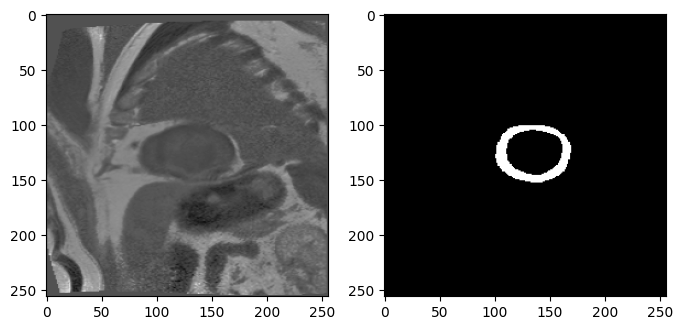

In [29]:


ind = 1
import matplotlib.pyplot as plt
import numpy as np

s = train_dataset[0][0].shape

img1 = np.array(train_dataset[ind][0], dtype=int)
print(f"{img1.shape}")


print(s)

img1 = np.array(train_dataset[ind][0], dtype=float).transpose((2,1,0)) 
# img1 = np.array(train_dataset[ind][0], dtype=int)
img1L = np.array(train_dataset[ind][1], dtype=int) 
print(img1L)

print(f"Unique labels = {np.unique(img1L)}")

print(f"{img1.shape}, Label -> {img1L.shape}")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow( img1 , cmap='gray', vmin=0, vmax=255)
ax[1].imshow( img1L*255 , cmap='gray' , vmin=0, vmax=255)
plt.show()


In [30]:
BATCH_SZ = 16

def dataloader():
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SZ, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SZ, shuffle=False, num_workers=2)

    return train_loader, test_loader


In [31]:
def train():
    start = time()
    train_loader, test_loader = dataloader()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model = SegNet(3, 2).to(device)
    model = SegNet(1, 2).to(device)

#     criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    lblWt = torch.tensor(np.array([1.0, wt_val]), dtype=torch.float, device=device)
    
    
    
    
    dss = []
    print("Dice score before training")
    for i in range(10):
        pten = torch.tensor(np.array([test_dataset[i][0]]), dtype=torch.float, device=device)

        pred = model(pten)

        p1 = np.array(pred.cpu().data.numpy())

        prednp = np.reshape(p1, (2, 256, 256))

        p2 = np.argmax(prednp, axis=0)

        ds = dice_score(np.array(test_dataset[i][1], dtype=int), p2)

        print(f"Before training: Test Image {i}. Dice score = {ds}")

        dss.append(ds)

    print(f"Before training: Mean Dice Score = {sum(dss)/len(dss)}")
    print("="*70)

    for epoch in range(NUM_EPOCHS):

#         print(f"\nEpoch = {epoch+1}")

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        model.train()

        for i, (images, labels) in enumerate(train_loader):

#             print(f"({i},{len(train_loader)})", end= ", ")

            images = torch.tensor(images, dtype=torch.long, device=device)
            labels = torch.tensor(labels, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(images.float())
#             loss, input, target = dice_loss2d(outputs, labels, lblWt)
            loss, input, target = cross_entropy2d(outputs, labels, lblWt)
            train_loss += loss.item()
            train_acc += (input.argmax(1) == target).sum().item()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc / (len(train_loader.dataset) * 256 * 256)

        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:

                images = torch.tensor(images, dtype=torch.long, device=device)
                labels = torch.tensor(labels, dtype=torch.long, device=device)

                outputs = model(images.float())

                # plt.imshow(outputs[0].cpu().numpy)
                # return
#                 loss, input, target = dice_loss2d(outputs, labels, lblWt)
                loss, input, target = cross_entropy2d(outputs, labels, lblWt)
                val_loss += loss.item()
                val_acc += (input.argmax(1) == target).sum().item()

        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / (len(test_loader.dataset) * 256 * 256)


        print('\nEpoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
              .format(epoch + 1, NUM_EPOCHS, i + 1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
        
        minLeft = (time() - start)/60
        print(f"\tTime elapsed = {minLeft:.2f} (mins). Approx time left = {((NUM_EPOCHS - epoch - 1)/(epoch + 1) * minLeft):.2f} (mins)")
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

    # plt.figure()
    # plt.plot(range(NUM_EPOCHS), train_loss_list, color='blue', linestyle='-', label='train_loss')
    # plt.plot(range(NUM_EPOCHS), val_loss_list, color='green', linestyle='--', label='val_loss')
    # plt.legend()
    # plt.xlabel('epoch')
    # plt.ylabel('loss')
    # plt.title('Training and validation loss')
    # plt.grid()
    #
    # plt.figure()
    # plt.plot(range(NUM_EPOCHS), train_acc_list, color='blue', linestyle='-', label='train_acc')
    # plt.plot(range(NUM_EPOCHS), val_acc_list, color='green', linestyle='--', label='val_acc')
    # plt.legend()
    # plt.xlabel('epoch')
    # plt.ylabel('acc')
    # plt.title('Training and validation accuracy')
    # plt.grid()

    torch.save(model.state_dict(), f"{write_to_path}/mlia/results/{model_name}")
    
    print(f"Training done in {(time() - start)/60} minutes.")
    return model


In [32]:
# TODO: Check This Code!
def cross_entropy2d(input, target, weight=None, size_average=True):
#     print(">> input.shape = ",input.shape)
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # n, c, h, w -> n, h, c, w -> n, h, w, c

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c) # -> shape: (X, c)
    target = target.view(-1)
    
#     print(f"input.shape = {input.shape}")
#     print(f"target.shape = {target.shape}")
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
#     print(f"Loss:{loss}")
    return loss, input, target

# def dice_loss2d(input, target, weight=None, size_average=True):
# #     print(">> input.shape = ",input.shape)

#     n, c, h, w = input.size()
#     nt, ht, wt = target.size()
    
#     input_soft = F.softmax(input, dim=1)

#     # create the labels one hot tensor
#     target_one_hot = F.one_hot(target, num_classes=input.shape[1])
#     target_one_hot = target_one_hot.transpose(1, 3)
    
# #     print(f"input_soft.shape = {input_soft.shape}")
# #     print(f"target_one_hot.shape = {target_one_hot.shape}")

#     # compute the actual dice score
#     dims = (1, 2, 3)
#     intersection = torch.sum(input_soft * target_one_hot, dims)
#     cardinality = torch.sum(input_soft + target_one_hot, dims)

#     dice_score = 2. * intersection / (cardinality + 0.00001)

#     # n, c, h, w -> n, h, c, w -> n, h, w, c

#     input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c) # -> shape: (X, c)
#     target = target.view(-1)
    
# #     print(f"input.shape = {input.shape}")
# #     print(f"target.shape = {target.shape}")
    
#     loss = torch.mean(1. - dice_score)
    
# #     print(f"Loss:{loss}")
    

#     return loss, input, target


In [33]:
# a = torch.tensor(np.array([[[1,2], [3, 4], [12,13],[78,79]] , [[5, 6], [7, 8],[34,35],[67,68]],
#                           [[35, 36], [71, 72],[55,56],[23,24]]]), dtype=torch.long, device='cuda')
# print(a)
# print(a.shape)
# b = a.transpose(0, 2)
# print(b)
# print(b.shape)

In [34]:
seg = train()

Dice score before training
Before training: Test Image 0. Dice score = 0.03790885451009003
Before training: Test Image 1. Dice score = 0.016338128212985924
Before training: Test Image 2. Dice score = 0.0334212238354206
Before training: Test Image 3. Dice score = 0.03613431053821908
Before training: Test Image 4. Dice score = 0.03039555386792152
Before training: Test Image 5. Dice score = 0.03710369651214741
Before training: Test Image 6. Dice score = 0.035677459257689746
Before training: Test Image 7. Dice score = 0.034332106355797545
Before training: Test Image 8. Dice score = 0.026295120026535834
Before training: Test Image 9. Dice score = 0.018220042039866838
Before training: Mean Dice Score = 0.030582649515667453


/tmp/ipykernel_156706/2508538640.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.long, device=device)
/tmp/ipykernel_156706/2508538640.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long, device=device)
/usr/local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Epoch [1/100], Loss: 0.0307, val_loss: 0.0290, val_acc: 0.8662
	Time elapsed = 0.83 (mins). Approx time left = 82.29 (mins)


/tmp/ipykernel_156706/2508538640.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.long, device=device)
/tmp/ipykernel_156706/2508538640.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long, device=device)



Epoch [2/100], Loss: 0.0174, val_loss: 0.0262, val_acc: 0.8567
	Time elapsed = 1.52 (mins). Approx time left = 74.64 (mins)

Epoch [3/100], Loss: 0.0144, val_loss: 0.0254, val_acc: 0.8526
	Time elapsed = 2.22 (mins). Approx time left = 71.88 (mins)

Epoch [4/100], Loss: 0.0127, val_loss: 0.0195, val_acc: 0.8926
	Time elapsed = 2.92 (mins). Approx time left = 70.12 (mins)

Epoch [5/100], Loss: 0.0115, val_loss: 0.0149, val_acc: 0.9395
	Time elapsed = 3.62 (mins). Approx time left = 68.81 (mins)

Epoch [6/100], Loss: 0.0105, val_loss: 0.0138, val_acc: 0.9335
	Time elapsed = 4.32 (mins). Approx time left = 67.63 (mins)

Epoch [7/100], Loss: 0.0099, val_loss: 0.0145, val_acc: 0.9452
	Time elapsed = 5.02 (mins). Approx time left = 66.72 (mins)

Epoch [8/100], Loss: 0.0093, val_loss: 0.0129, val_acc: 0.9396
	Time elapsed = 5.72 (mins). Approx time left = 65.81 (mins)

Epoch [9/100], Loss: 0.0087, val_loss: 0.0127, val_acc: 0.9381
	Time elapsed = 6.43 (mins). Approx time left = 64.97 (mins)


In [35]:
def print_minmax(x):
    print(f"Min = {np.min(x)}, Max = {np.max(x)}")

Device = cuda
Min = 8.0, Max = 228.0
<class 'torch.Tensor'>
torch.Size([1, 2, 256, 256])
p1 shape = (1, 2, 256, 256)
p2 shape = (256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(256, 256, 1), Label -> (256, 256)
[0 1]


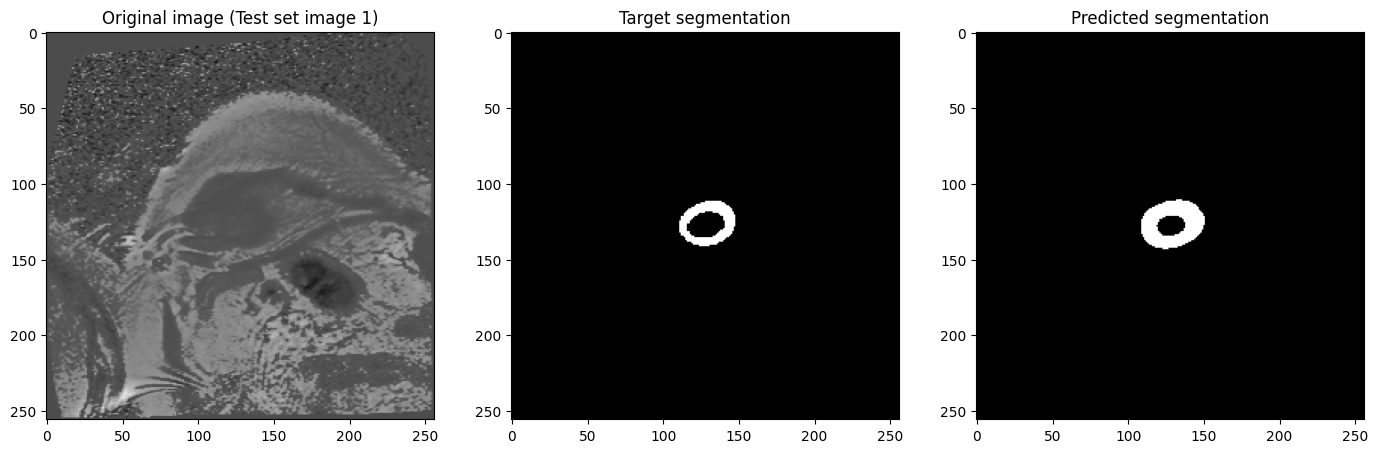

In [36]:


ind = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device = {device}")
# pten = torch.tensor(np.array([train_dataset[ind][0]]), dtype=torch.float, device=device)
pten = torch.tensor(np.array([test_dataset[ind][0]]), dtype=torch.float, device=device)

print_minmax( np.array([test_dataset[ind][0]]) )

pred = seg(pten)
print(type(pred))
print(pred.shape)

p1 = np.array(pred.cpu().data.numpy())

print(f"p1 shape = {p1.shape}")

prednp = np.reshape(p1, (2, 256, 256))

p2 = np.argmax(prednp, axis=0)

print(f"p2 shape = {p2.shape}")

print(p2)


img1 = np.array(test_dataset[ind][0], dtype=int).transpose((2,1,0)) 
img1L = np.array(test_dataset[ind][1], dtype=int) 

print(f"{img1.shape}, Label -> {img1L.shape}")


fig, ax = plt.subplots(1, 3, figsize=(17, 7))
# print(train_dataset[0][0])
ax[0].set_title(f"Original image (Test set image {ind})")
ax[0].imshow( img1 , cmap = 'gray', vmin=0, vmax=255)
ax[1].set_title('Target segmentation')
ax[1].imshow( img1L*255 , cmap='gray' , vmin=0, vmax=255)
ax[2].set_title('Predicted segmentation')
ax[2].imshow(p2*255, cmap='gray', vmin=0, vmax=255)
print(np.unique(p2))


In [37]:
sm = 0
ct = 0
for h in range(len(train_dataset)):
    ovY = np.array(train_dataset[h][1], dtype=int) 
    u, cts = (np.unique(ovY, return_counts=True))
    if len(cts)==2:
        prp = (cts[1]/cts[0])
#         print(prp, 1/prp)
        sm += prp

    ct += 1
    
#     print(np.unique(p2, return_counts=True))

print(f"Average class proportion: {sm/ct}, {ct/sm}")

Average class proportion: 0.024674258337151703, 40.52806720007115


In [5]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device = {device}")

dss = []

for i in range(10):
    pten = torch.tensor(np.array([test_dataset[i][0]]), dtype=torch.float, device=device)
    
#     print(np.array([test_dataset[i][0]]).shape)
    
    pred = seg(pten)
    
    p1 = np.array(pred.cpu().data.numpy())

    prednp = np.reshape(p1, (2, 256, 256))

    p2 = np.argmax(prednp, axis=0)
    
    ds = dice_score(np.array(test_dataset[i][1], dtype=int), p2)
    
    print(f"Test Image {i}. Dice score = {ds}")
    
    dss.append(ds)
    
print(f"Mean Dice Score = {sum(dss)/len(dss)}")
    
    
    

Device = cuda


NameError: name 'test_dataset' is not defined

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device = {device}")

seg = SegNet(1, 2).to(device)
seg.load_state_dict(torch.load(f"{write_to_path}/mlia/results/{model_name}"))


Device = cuda


<All keys matched successfully>

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device = {device}")

dss = []

for i in range(10):
    pten = torch.tensor(np.array([test_dataset[i][0]]), dtype=torch.float, device=device)
    
#     print(np.array([test_dataset[i][0]]).shape)
    
    pred = seg(pten)
    
    p1 = np.array(pred.cpu().data.numpy())

    prednp = np.reshape(p1, (2, 256, 256))

    p2 = np.argmax(prednp, axis=0)
    
    ds = dice_score(np.array(test_dataset[i][1], dtype=int), p2)
    
    print(f"Test Image {i}. Dice score = {ds}")
    
    dss.append(ds)
    
print(f"Mean Dice Score = {sum(dss)/len(dss)}")
    

Device = cuda
Test Image 0. Dice score = 0.7284617551081554
Test Image 1. Dice score = 0.6494597800152474
Test Image 2. Dice score = 0.7315242473108422
Test Image 3. Dice score = 0.7883959021945509
Test Image 4. Dice score = 0.710975607588489
Test Image 5. Dice score = 0.7623880574257073
Test Image 6. Dice score = 0.7415458914808396
Test Image 7. Dice score = 0.7731196030421713
Test Image 8. Dice score = 0.795088254815471
Test Image 9. Dice score = 0.7041357332760566
Mean Dice Score = 0.738509483225753


['/home/ufh6ft/mlia/data_imgs_aug/train/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00100.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00200.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00300.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00400.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00500.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00600.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00700.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00800.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00900.png']
['/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00100.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00200.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00300.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00400.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00500.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00600.png', '/home/ufh6ft/mlia/data_imgs

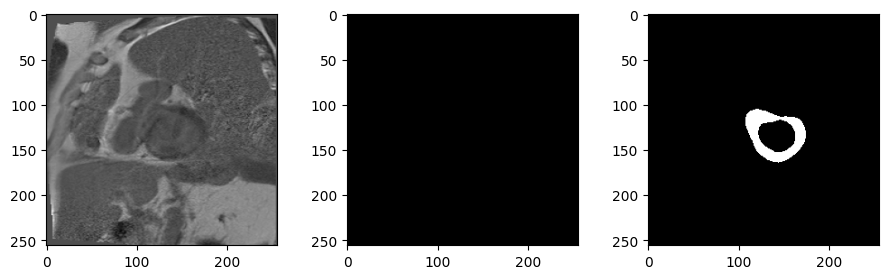

Test img 1
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


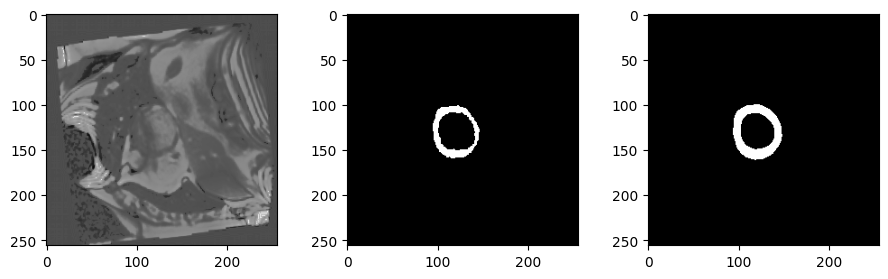

Test img 2
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


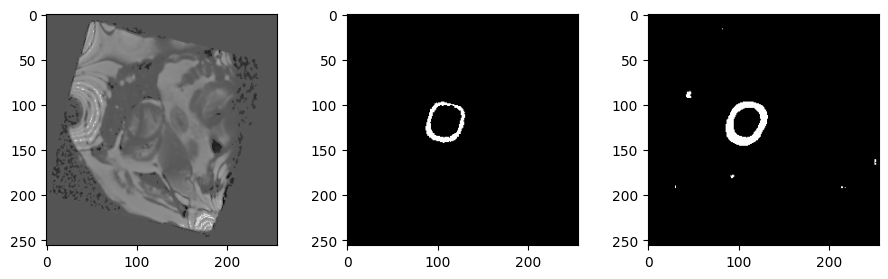

Test img 3
Min = 8, Max = 228
Min = 0, Max = 0
(1, 256, 256)


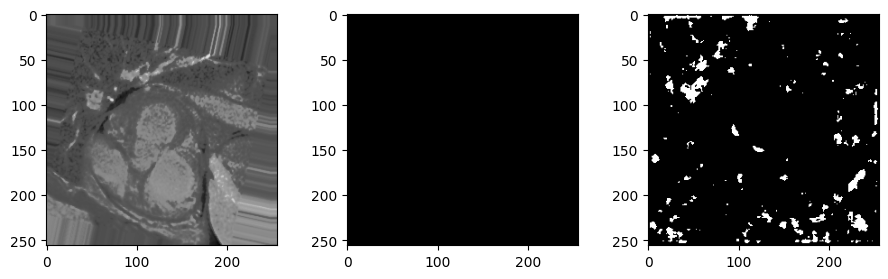

Test img 4
Min = 13, Max = 228
Min = 0, Max = 255
(1, 256, 256)


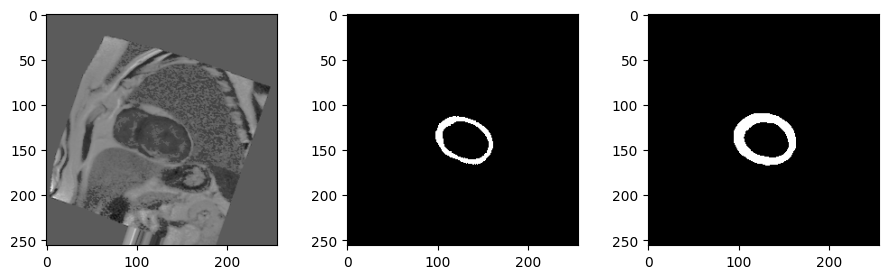

Test img 5
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


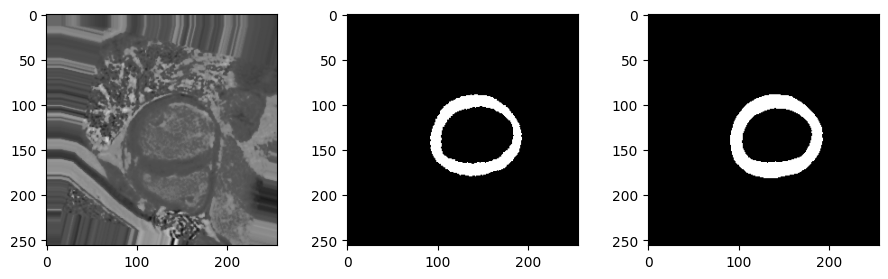

Test img 6
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


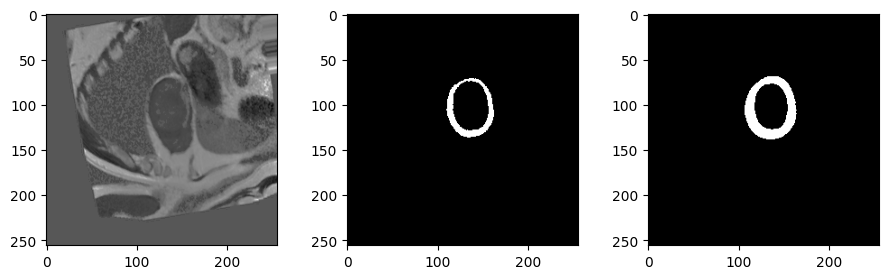

Test img 7
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


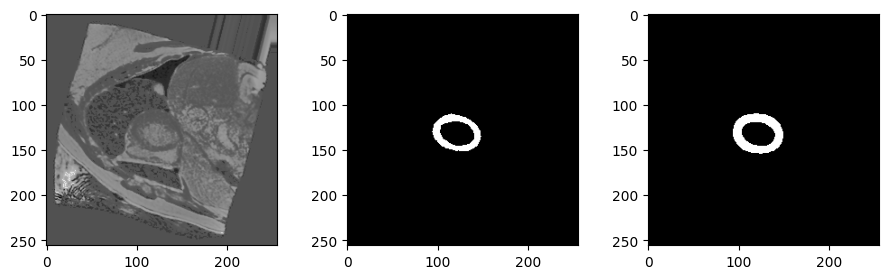

Test img 8
Min = 26, Max = 228
Min = 0, Max = 255
(1, 256, 256)


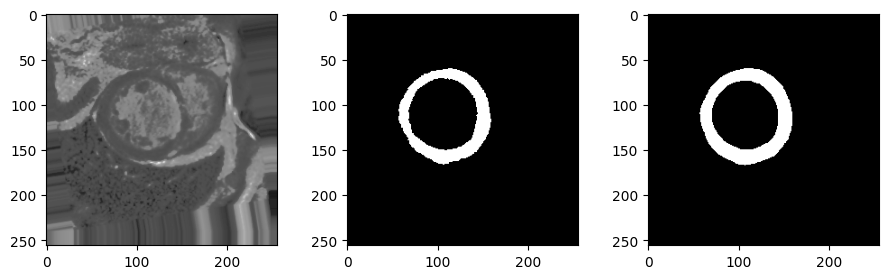

Test img 9
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


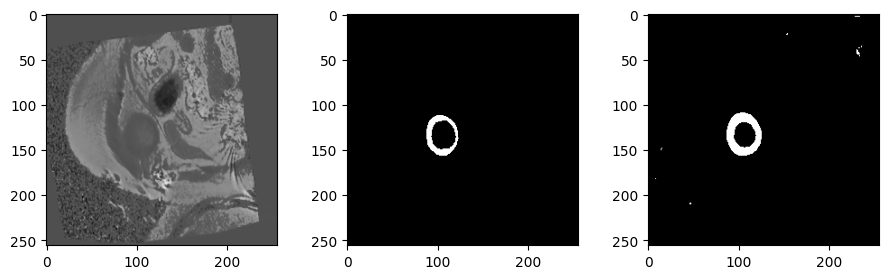

In [41]:
lBase = f"{write_to_path}/mlia/data_imgs_aug/train/"
lBaseY = f"{write_to_path}/mlia/data_imgs_aug/trainannot/"

lTestPaths = [lBase+"img_"+("0"*(5 - len(str(ct)))) + str(ct) +".png" for ct in range(0, 1000, 100)]
lTestPathsY = [lBaseY+"img_"+("0"*(5 - len(str(ct)))) + str(ct) +".png" for ct in range(0, 1000, 100)]

print(lTestPaths)
print(lTestPathsY)

ct = 0
for p, pY in zip(lTestPaths, lTestPathsY):
    print(f"Train img {ct}")
    ct+=1

    im = cv2.imread(p, 0)
    imY = cv2.imread(pY, 0)
    
    print_minmax(im)
    print_minmax(imY)
    
    image = np.reshape(im, (256, 256, 1)).transpose(2, 1, 0).astype('float')
    
    pten = torch.tensor(np.reshape( np.array(image) , (1, 1, 256, 256)), dtype=torch.float, device=device)
    
    print(np.array(image).shape)
    
    pred = seg(pten)
    
    p1 = np.array(pred.cpu().data.numpy())

    prednp = np.reshape(p1, (2, 256, 256))

    p2 = np.argmax(prednp, axis=0)
    
    fig, ax = plt.subplots(1, 3, figsize=(11, 3))
    ax[0].imshow(im, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(imY, cmap='gray', vmin=0, vmax=255)
    ax[2].imshow(p2*255, cmap='gray', vmin=0, vmax=255)
    plt.show()

print("="*100)

['/home/ufh6ft/mlia/data_imgs_aug/test/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00001.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00002.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00003.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00004.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00005.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00006.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00007.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00008.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00009.png']
['/home/ufh6ft/mlia/data_imgs_aug/testannot/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/testannot/img_00001.png', '/home/ufh6ft/mlia/data_imgs_aug/testannot/img_00002.png', '/home/ufh6ft/mlia/data_imgs_aug/testannot/img_00003.png', '/home/ufh6ft/mlia/data_imgs_aug/testannot/img_00004.png', '/home/ufh6ft/mlia/data_imgs_aug/testannot/img_00005.png', '/home/ufh6ft/mlia/data_imgs_aug/testannot/img_00006.png', '/home/ufh6ft/mlia/data_imgs_aug/testannot/im

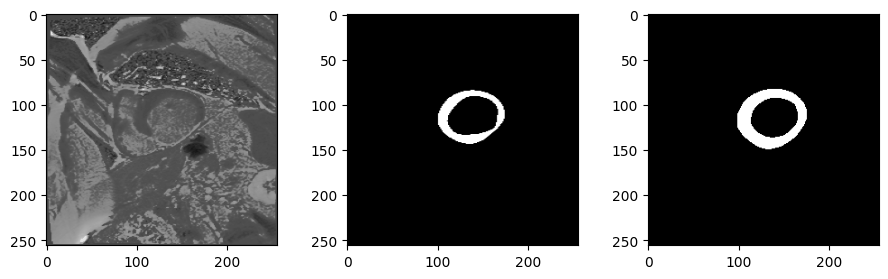

Test img 1
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


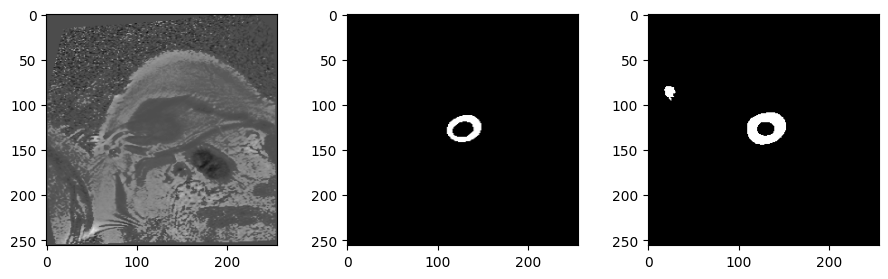

Test img 2
Min = 9, Max = 228
Min = 0, Max = 255
(1, 256, 256)


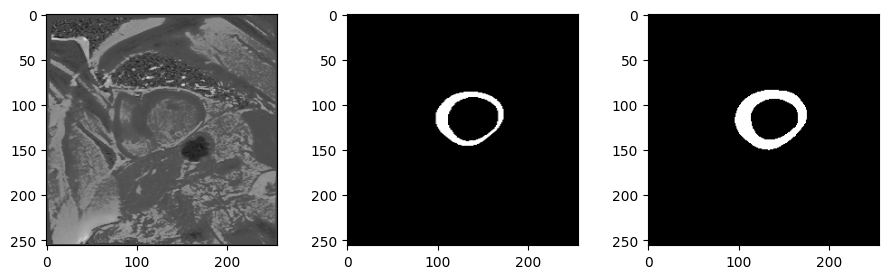

Test img 3
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


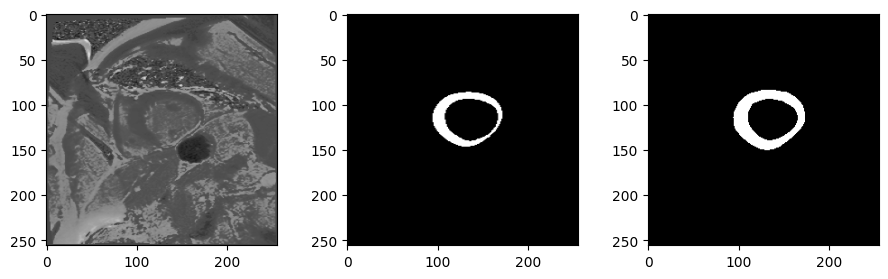

Test img 4
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


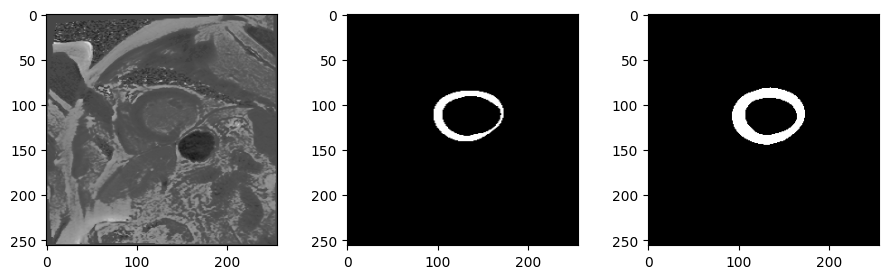

Test img 5
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


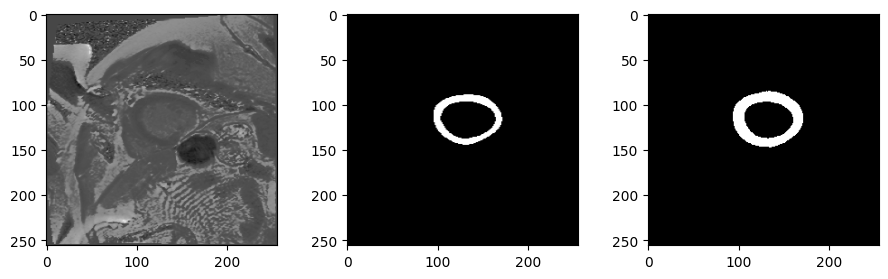

Test img 6
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


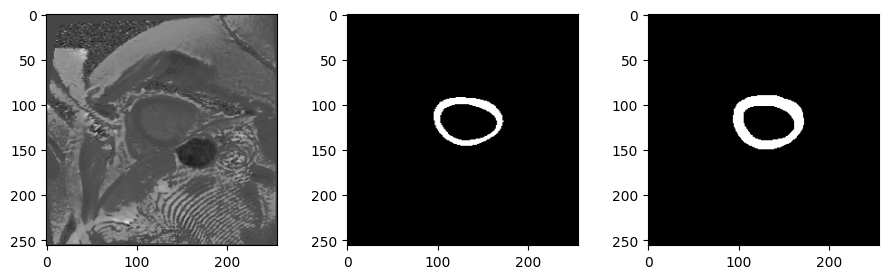

Test img 7
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


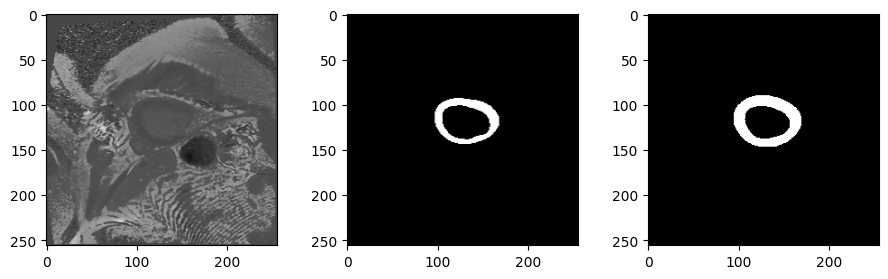

Test img 8
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


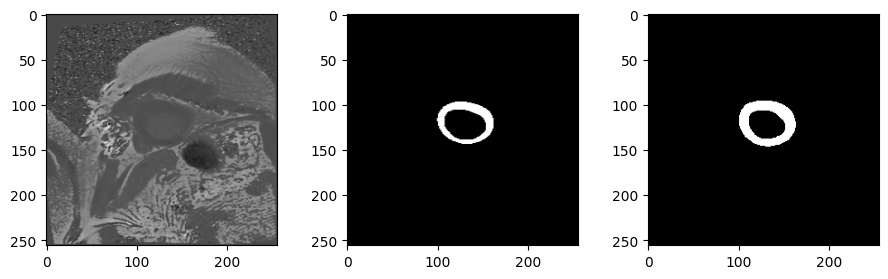

Test img 9
Min = 8, Max = 228
Min = 0, Max = 255
(1, 256, 256)


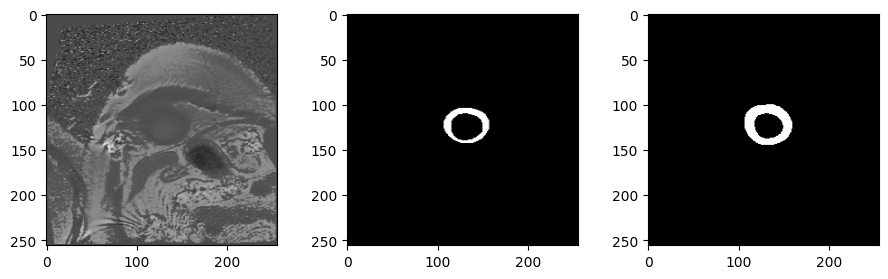

['/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00001.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00002.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00003.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00004.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00005.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00006.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00007.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00008.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00009.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00010.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00011.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00012.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00013.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00014.png', '/home/ufh6ft/mlia/data_imgs_aug/testNoLabel/img_00015.png']
Test img 0
Min = 62, Ma

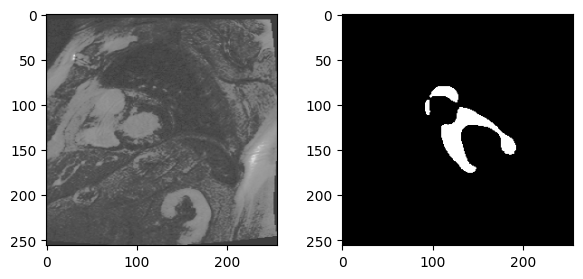

Test img 1
Min = 61, Max = 228
(1, 256, 256)


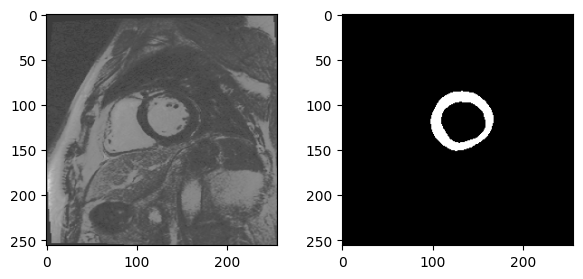

Test img 2
Min = 61, Max = 228
(1, 256, 256)


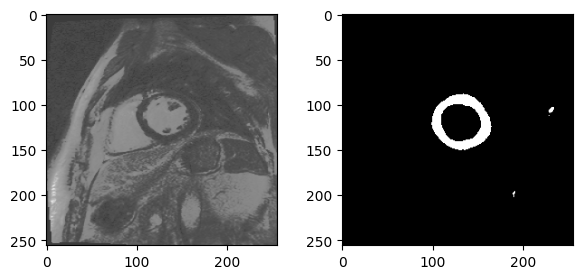

Test img 3
Min = 61, Max = 228
(1, 256, 256)


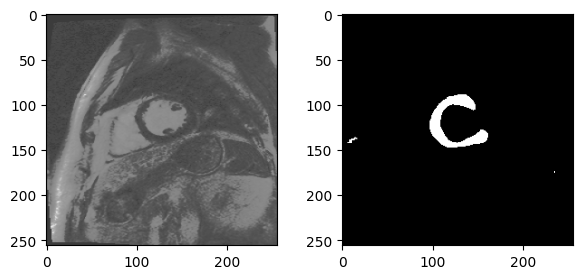

Test img 4
Min = 61, Max = 228
(1, 256, 256)


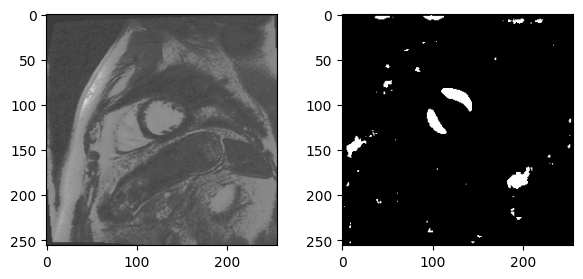

Test img 5
Min = 61, Max = 228
(1, 256, 256)


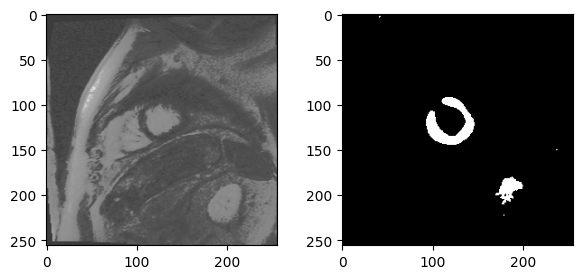

Test img 6
Min = 61, Max = 228
(1, 256, 256)


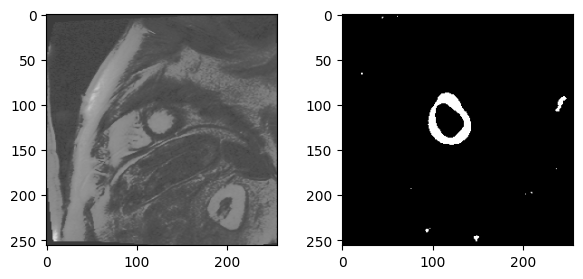

Test img 7
Min = 61, Max = 228
(1, 256, 256)


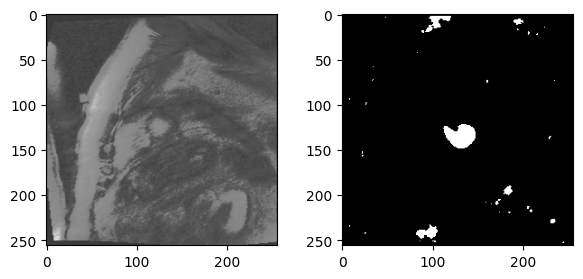

Test img 8
Min = 64, Max = 228
(1, 256, 256)


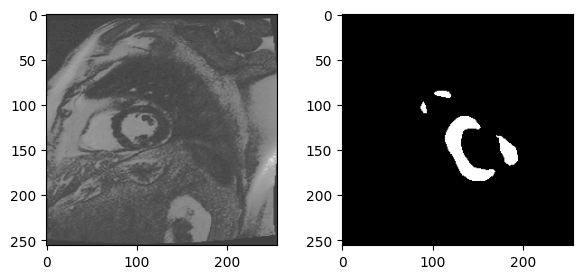

Test img 9
Min = 65, Max = 228
(1, 256, 256)


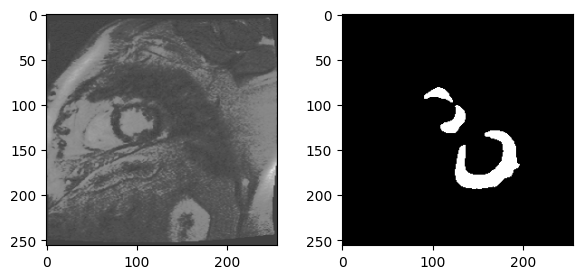

Test img 10
Min = 65, Max = 228
(1, 256, 256)


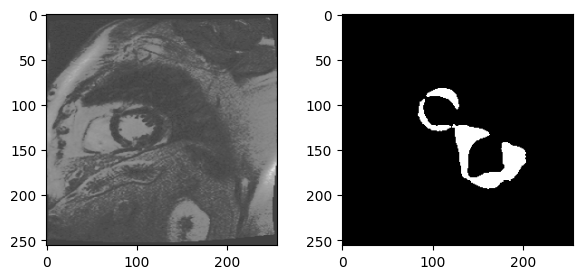

Test img 11
Min = 63, Max = 228
(1, 256, 256)


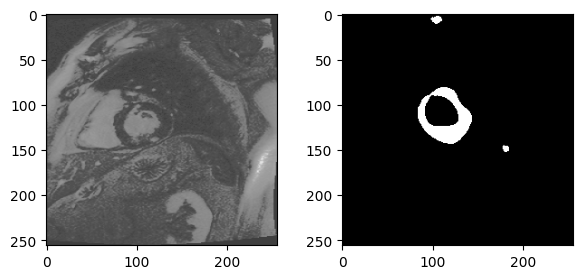

Test img 12
Min = 66, Max = 228
(1, 256, 256)


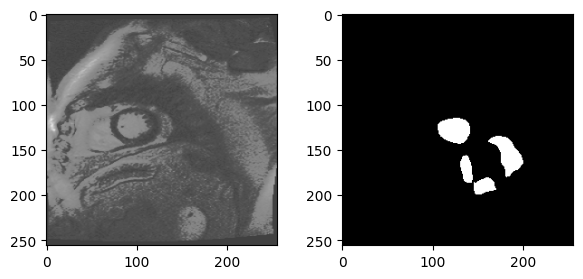

Test img 13
Min = 66, Max = 228
(1, 256, 256)


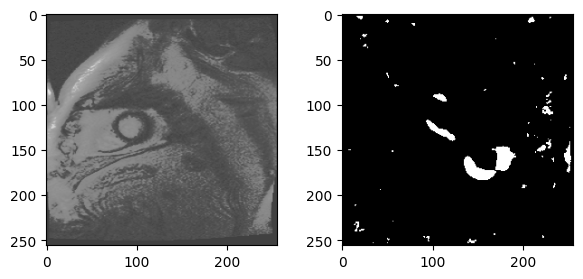

Test img 14
Min = 67, Max = 228
(1, 256, 256)


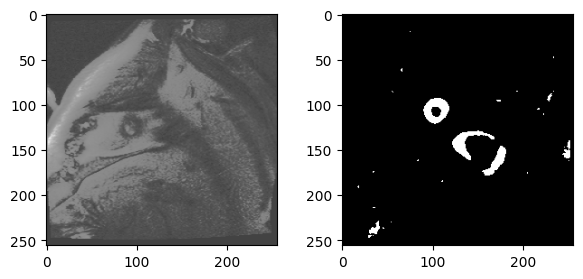

Test img 15
Min = 61, Max = 228
(1, 256, 256)


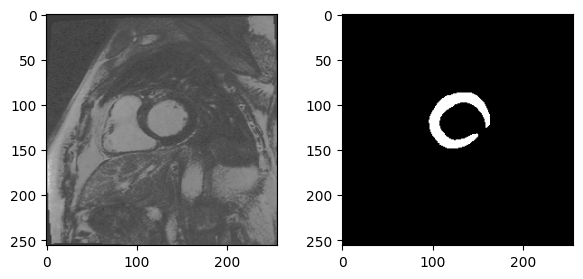

In [42]:
lBase = f"{write_to_path}/mlia/data_imgs_aug/test/"
lBaseY = f"{write_to_path}/mlia/data_imgs_aug/testannot/"

lTestPaths = [lBase+"img_"+("0"*(5 - len(str(ct)))) + str(ct) +".png" for ct in range(10)]
lTestPathsY = [lBaseY+"img_"+("0"*(5 - len(str(ct)))) + str(ct) +".png" for ct in range(10)]

print(lTestPaths)
print(lTestPathsY)

ct = 0
for p, pY in zip(lTestPaths, lTestPathsY):
    print(f"Test img {ct}")
    ct+=1

    im = cv2.imread(p, 0)
    imY = cv2.imread(pY, 0)
    
    print_minmax(im)
    print_minmax(imY)
    
    image = np.reshape(im, (256, 256, 1)).transpose(2, 1, 0).astype('float')
    
    pten = torch.tensor(np.reshape( np.array(image) , (1, 1, 256, 256)), dtype=torch.float, device=device)
    
    print(np.array(image).shape)
    
    pred = seg(pten)
    
    p1 = np.array(pred.cpu().data.numpy())

    prednp = np.reshape(p1, (2, 256, 256))

    p2 = np.argmax(prednp, axis=0)
    
    fig, ax = plt.subplots(1, 3, figsize=(11, 3))
    ax[0].imshow(im, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(imY, cmap='gray', vmin=0, vmax=255)
    ax[2].imshow(p2*255, cmap='gray', vmin=0, vmax=255)
    plt.show()

print("="*100)

nlBase = f"{write_to_path}/mlia/data_imgs_aug/testNoLabel/"

nlTestPaths = [nlBase+"img_"+("0"*(5 - len(str(ct)))) + str(ct) +".png" for ct in range(16)]

print(nlTestPaths)

ct = 0
for p in nlTestPaths:
    print(f"Unlabeled Test img {ct}")
    ct+=1

    im = cv2.imread(p, 0)
    
    print_minmax(im)
    
    image = np.reshape(im, (256, 256, 1)).transpose(2, 1, 0).astype('float')
    
    pten = torch.tensor(np.reshape( np.array(image) , (1, 1, 256, 256)), dtype=torch.float, device=device)
    
    print(np.array(image).shape)
    
    pred = seg(pten)
    
    p1 = np.array(pred.cpu().data.numpy())

    prednp = np.reshape(p1, (2, 256, 256))

    p2 = np.argmax(prednp, axis=0)
    
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    ax[0].imshow(im, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(p2*255, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
    
    
    
    
    
    